In [24]:
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import REST, TimeFrame
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
import numpy as np
from time import sleep
from datetime import datetime
from dateutil.relativedelta import relativedelta

def import_data(api, dates):
  btc = api.get_crypto_bars('BTCUSD','15Min', dates[0],dates[1]).df
  btc = btc.reset_index()
  btc = btc[btc['exchange'] == 'CBSE']
  dates = pd.to_datetime(btc['timestamp']).dt.tz_convert(None)
  btc['time'] = (dates - pd.Timestamp('1970-01-01')) //pd.Timedelta('1s')
  return btc

def add_lag(df, col_to_lag, lag):
  dataset = df.copy()
  for i in range(lag):
    dataset[f'{col_to_lag}_lag_{i+1}'] = dataset[col_to_lag].shift(i+1)
  return dataset

def create_target(df_close, future_step,target_from):
  df = df_close.copy()
  df['future_'+ str(future_step)] = df['close'].shift(-future_step)
  df['diff'] = df['future_'+ str(future_step)] - df['close']
  df['class'] = np.where((df['diff'] > 0), 1, 0)
  return df

def make_dataset(lag_num,future ,dates,api):
  btc = import_data(api, dates)
  data = create_target(pd.DataFrame(btc['close']), future, 'close')
  lag = add_lag(pd.DataFrame(data['close']), 'close', lag_num)
  dataset = pd.concat([lag, data.drop('close', axis = 1)], axis = 1)
  dataset['time'] = btc['time']
  dataset = dataset.iloc[lag_num:]
  dataset = dataset.iloc[0:-future]
  return dataset

def get_position(symbol):
  positions = alpaca.list_positions()
  for p in positions:
    if p.symbol == symbol:
      return float(p.qty)
  return 0

def get_input(symbol, length):
  bars = alpaca.get_crypto_bars(symbol, '15Min').df
  bars = bars[bars['exchange'] == 'CBSE']
  out = {}
  out['close'] = bars['close'].iloc[-1]
  for _ in range(1, length+1):
    i = 2
    out['close_lag_'+str(_)] = bars['close'].iloc[-i]
    i+=1
  return pd.DataFrame(out, index = [0])

def rmse(actual, predict):
  return np.sqrt(np.mean((actual - predict)**2))

def train_model(training_data, tr_cols, target):
  print(training_data.columns)
  lm = LinearRegression()
  lm.fit(training_data[tr_cols], training_data[target])
  return lm

def test(model,data,train_index, feature_cols, target):
  mod = model
  train = data.iloc[:train_index]
  test = data.iloc[train_index:]
  train_pred = mod.predict(train[feature_cols])
  y_pred = mod.predict(test[feature_cols])
  print('Training RMSE: ', rmse(train[target], train_pred))
  print('Test RMSE: ',rmse(test[target], y_pred))
  
  test['y_pred'] = y_pred
  test['y_pred_diff'] = test['future_60'] - test['y_pred']
  test['mvnt'] = np.where((test['y_pred_diff']) > 0,1,0)
  print('Test Accuracy: ',accuracy_score(test['mvnt'],test['class']))


credentials = {'key':'PKA34K1SAVG8GUCS1DG1',
               'secret_key':'slfVviLDQuwmcwC8VpTZ2qbkYPOsKQ2dVnLXCeGl',
               'url':'https://paper-api.alpaca.markets'}

print('*** ACTIVATING ***')
alpaca = tradeapi.REST(credentials['key'],credentials['secret_key'], base_url = credentials['url'])
print('*** Connected to API *** ')
portfolio_value = float(alpaca.get_account().equity)


print('*** CLOSING OPEN POSITIONS ***')
alpaca.close_all_positions()

print('*** HOURLY MODE ***')
print('Current Value:', portfolio_value) 


#train once


# test(model,hist_data,int(hist_data.shape[0]*.7), hist_data.columns[:-4], 'future_4')
# run forever
while True:

  today = datetime.now().isoformat()[:10]
  yr_ago = (datetime.now() - relativedelta(days = 7)).isoformat()[:10]
  dates = [yr_ago, today]
  hist_data = make_dataset(10, 4, dates,alpaca)
  print(hist_data.columns)
  
  #print(hist_data.columns)
  model = train_model(hist_data,hist_data.columns[:-4], 'future_4')
  #test(model,hist_data,int(hist_data.shape[0]*.7), hist_data.columns[:-4], 'future_4' )
  input = get_input('BTCUSD', 10) 
  y_pred = model.predict(input)
  threshold = input['close'].iloc[0]
 
  if get_position('BTCUSD') == 0 and y_pred > threshold: #if not holding and going up BUY
    alpaca.submit_order('BTCUSD', qty = 1, side = 'buy')
    sleep(0.5)
    pos = alpaca.get_position('BTCUSD').market_value
    new_value = float(alpaca.get_account().equity)
    print(str(datetime.now())[:19]+f' - Bought BTC @ {pos} | Projected Value = {y_pred} | Threshold: {threshold} | Portfolio Value: {new_value}' )

  elif (get_position('BTCUSD') == 1):# and y_pred < input['close']) or (new_value - portfolio_value) < -500: #if holding and going down SELL
    alpaca.close_position('BTCUSD')
    new_value = float(alpaca.get_account().equity)
    if new_value > portfolio_value:
      print(str(datetime.now())[:19]+f'- **SOLD BTC @ {new_value - portfolio_value}$ PROFIT** | Portfolio Value: {new_value}')
      porfolio_value = new_value
    else:
      print(str(datetime.now())[:19]+f'- Sold BTC @ {new_value - portfolio_value}$ loss** | Portfolio Value: {new_value}')
      porfolio_value = new_value
    
  # elif get_position('BTCUSD'):
  #   curr_btc_value = alpaca.get_position('BTCUSD').market_value
  #   print(str(datetime.now())[:19]+f' - Position Held @ {curr_btc_value} | Current Profit: {new_value - portfolio_value} | Projected Value: {y_pred} | Portfolio Value: {new_value}')
  else:
    cl = input['close'].iloc[0]
    print(str(datetime.now())[:19]+f'- No Action Taken | Close: {cl} | Predicted: {y_pred} | Threshold: {threshold} | Portfolio Value: {portfolio_value}')
  
  if get_position('BTCUSD') == 1:
    print('Wainting 1 Hour')
    sleep(3600) #sleep for an hour
  else:
    print('Waiting 5 Mins')
    sleep(60*5)

*** ACTIVATING ***
*** Connected to API *** 
*** CLOSING OPEN POSITIONS ***
*** HOURLY MODE ***
Current Value: 98438.56


In [25]:
today = datetime.now().isoformat()[:10]
yr_ago = (datetime.now() - relativedelta(days = 7)).isoformat()[:10]
dates = [yr_ago, today]
hist_data = make_dataset(10, 4, dates,alpaca)

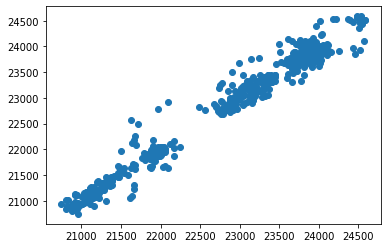

In [27]:
import matplotlib.pyplot as plt
plt.scatter(hist_data['close'], hist_data['future_4'])

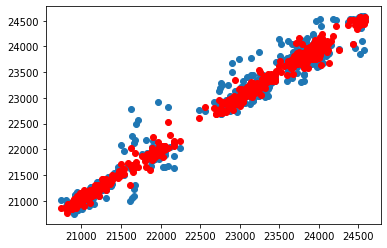

In [30]:
lm = LinearRegression()
X = hist_data.drop(['future_4', 'diff', 'class'], axis = 1)
y = hist_data['future_4']
lm.fit(X,y)
y_pred = lm.predict(X)

plt.scatter(hist_data['close_lag_1'], hist_data['future_4'])
plt.scatter(hist_data['close_lag_1'], y_pred, color = 'red')

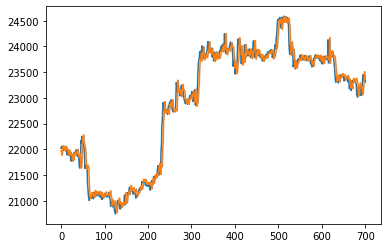

In [31]:
plt.plot(y.reset_index(drop = True))
plt.plot(y_pred)

In [33]:
input = get_input('BTCUSD', 10)
input

,close,close_lag_1,close_lag_2,close_lag_3,close_lag_4,close_lag_5,close_lag_6,close_lag_7,close_lag_8,close_lag_9,close_lag_10
0,23335.51,23315.65,23315.65,23315.65,23315.65,23315.65,23315.65,23315.65,23315.65,23315.65,23315.65
